In [1]:
import os
os.chdir('..')

In [2]:
import diag_vae.constants as const
import pandas as pd
from diag_vae.vanilla_tcn_ae import VanillaTcnAE
from diag_vae.diag_tcn_ae import DiagTcnAE
from diag_vae.diag_tcn_ae_predictor import DiagTcnAePredictor
from diag_vae.diag_tcn_ae_single_comp import DiagTcnAeSingleComp
from diag_vae.berfipl_datamodule import BERFIPLDataModule, BERFIPLDataSet
import matplotlib.pyplot as plt
import torch
import numpy as np
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tqdm

Global seed set to 42


## One AE per component

In [9]:
comp = list(const.BERFIPL_SIGNALS_MAP.keys())[0]
comp

'mixer_partial0.valve_V204'

In [11]:
loggs_dir = f'./logs/VanillaTcnComp_{comp}/version_0/checkpoints/'
checkpoint = os.path.join(loggs_dir, f'{os.listdir(loggs_dir)[1]}')
model = VanillaTcnAE.load_from_checkpoint(checkpoint)

In [16]:
SAMPLE_IDX = 100
# SAMPLE_IDX = 350000
test_data_paths = ['./data/raw/data/ds1/ds1n.csv',
                   './data/raw/data/ds1/ds1c.csv',
                   './data/raw/data/ds1/ds1l.csv',
                   './data/raw/data/ds1/ds1lc.csv']

ds_n, ds_c, ds_l, ds_lc = [BERFIPLDataSet(
        symbols_dct=const.BERFIPL_SIGNALS_MAP,
        data_path=test_data_paths[0],
        seq_len_x=500,
        split='test',
        val_split=.99,
        test_data_path=path,
        cols=const.BERFIPL_SIGNALS_MAP[comp],
        diag_ls=False,
) for path in test_data_paths]

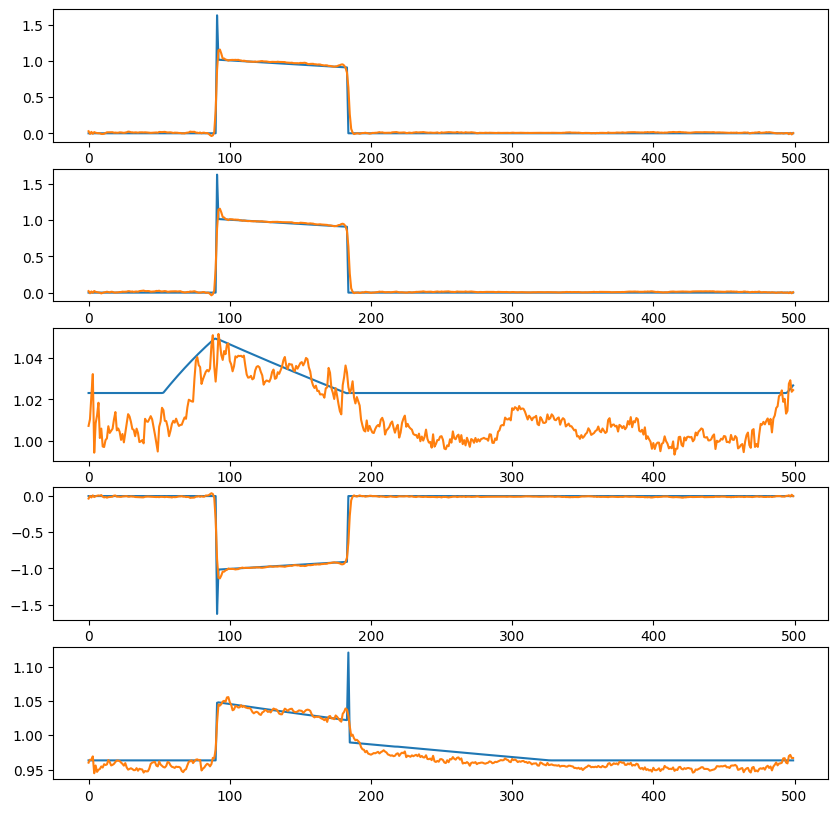

In [23]:
x, _, _ = ds_n.__getitem__(3500)
z_ae = model.encode(x)
x_ae_hat = model.decode(z_ae)
COMP = 1
num_sigs = x.shape[0]
fig, axs = plt.subplots(num_sigs, 1, figsize=(10, 10))
for i in range(num_sigs):
    axs[i].plot(x[i,:])
    axs[i].plot(x_ae_hat.detach().numpy()[0,i,:])
fig.show()(

In [43]:
import torch
def get_recon_errors_for_ds(ds, freq=10):
    recon_ls = []
    for idx in tqdm.tqdm(list(range(0, len(ds)))[::freq]):
        with torch.no_grad():
            x, _, _ = ds.__getitem__(idx)
            z_ae = model.encode(x)
            x_hat = model.decode(z_ae)
            recon_ls.append(torch.nn.MSELoss()(x, x_hat[0,:,:]))
    # array = np.stack(recon_ls)
    return np.stack(recon_ls)

In [46]:
recon_c = get_recon_errors_for_ds(ds_c,  freq=10)

100%|██████████| 374/374 [00:09<00:00, 39.08it/s]


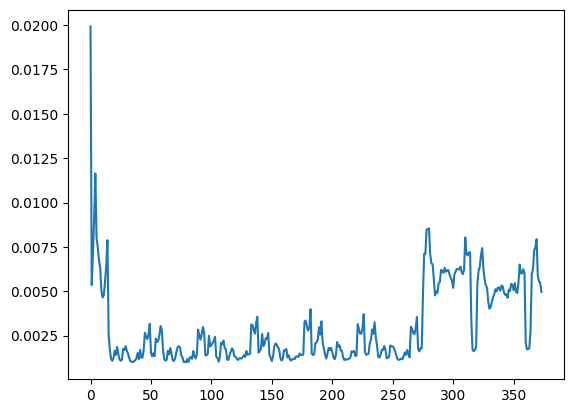

In [47]:
plt.plot(recon_c)

In [30]:
recon_ls = []
x, _, _ = ds_c.__getitem__(0)
z_ae = model.encode(x)
x_hat = model.decode(z_ae)
recon_ls.append(torch.nn.MSELoss()(x, x_hat))

In [19]:
x, _, _ = ds_n.__getitem__(3500)
z_ae = model.encode(x)
x_hat_ls = model.decode(z_ae)

In [20]:
x_hat_ls.shape

torch.Size([1, 5, 500])

In [48]:
loggs_dir = './logs/DiagTcnAE/version_33/checkpoints/'
checkpoint = os.path.join(loggs_dir, f'{os.listdir(loggs_dir)[1]}')
diag_ae_model = DiagTcnAE.load_from_checkpoint(checkpoint)

In [49]:
# loggs_dir = './logs/DiagTcnAeSingleComp/version_4/checkpoints/'
# checkpoint = os.path.join(loggs_dir, f'{os.listdir(loggs_dir)[0]}')
# diag_ae_model = DiagTcnAeSingleComp.load_from_checkpoint(checkpoint)

In [50]:
SAMPLE_IDX = 100
# SAMPLE_IDX = 350000
test_data_paths = ['./data/raw/data/ds1/ds1n.csv',
                   './data/raw/data/ds1/ds1c.csv',
                   './data/raw/data/ds1/ds1l.csv',
                   './data/raw/data/ds1/ds1lc.csv']

ds_n, ds_c, ds_l, ds_lc = [BERFIPLDataSet(
        cols=const.BERFIPL_COLS,
        symbols_dct=const.BERFIPL_SIGNALS_MAP,
        data_path=test_data_paths[0],
        seq_len_x=500,
        split='test',
        val_split=.99,
        test_data_path=path
) for path in test_data_paths]

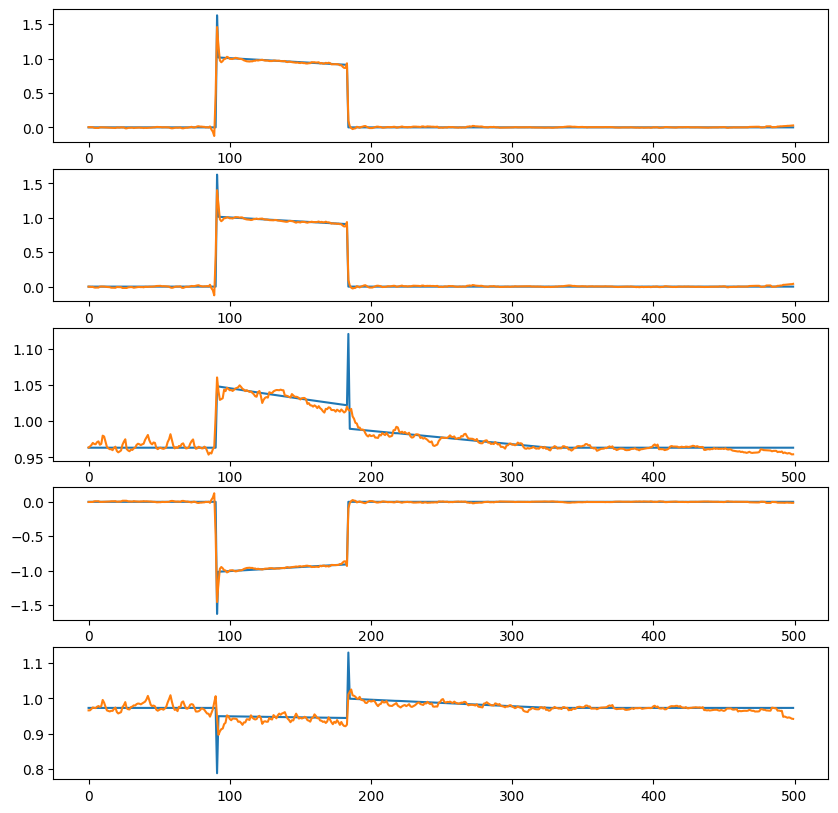

In [51]:
x, x_comp_list, _ = ds_n.__getitem__(3500)
z_diag_ae = diag_ae_model.encode(x)
x_diag_ae_hat_ls = diag_ae_model.decode(z_diag_ae)
COMP = 1
num_sigs = x_comp_list[COMP].shape[0]
fig, axs = plt.subplots(num_sigs, 1, figsize=(10, 10))
for i in range(num_sigs):
    axs[i].plot(x_comp_list[COMP][i,:])
    axs[i].plot(x_diag_ae_hat_ls[COMP].detach().numpy()[0,i,:])
fig.show()

In [52]:
def get_recon_errors_for_ds(ds, freq=10):
    recon_ls = []
    for idx in tqdm.tqdm(list(range(0, len(ds)))[::freq]):
        with torch.no_grad():
            x, x_comp_list, _ = ds.__getitem__(idx)
            out = diag_ae_model.predict_step((x, x_comp_list, _), batch_idx=1)
            recon_ls.append(torch.cat(out).numpy())
    array = np.stack(recon_ls, axis=1).T
    df = pd.DataFrame(array, columns=list(const.BERFIPL_SIGNALS_MAP.keys()))
    return df

In [53]:
df_recon_n = get_recon_errors_for_ds(ds_n, freq=10)

100%|██████████| 374/374 [01:43<00:00,  3.62it/s]


In [54]:
df_recon_l = get_recon_errors_for_ds(ds_l, freq=10)

100%|██████████| 374/374 [01:44<00:00,  3.57it/s]


In [55]:
df_recon_c = get_recon_errors_for_ds(ds_c, freq=10)

100%|██████████| 374/374 [01:45<00:00,  3.55it/s]


In [56]:
df_recon_lc = get_recon_errors_for_ds(ds_lc, freq=10)

100%|██████████| 374/374 [01:45<00:00,  3.56it/s]


In [64]:
def plot_recon_error(df):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    for c in df.columns:
        fig.add_trace(
            go.Scatter(x=df.index,
                       y=df[c], name=c),
            row=1, col=1,
        )
    fig.show()

In [77]:
def plot_recon_error_symb(df, symb):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    fig.add_trace(
        go.Scatter(x=df.index,
                   y=df[symb], name=symb),
        row=1, col=1,
    )
    threshold = df_recon_n[symb].mean()+7*df_recon_n[symb].std()
    fig.add_hrect(y0=0, y1=threshold, fillcolor="green", opacity=0.25, line_width=0,)
    fig.update_layout(title=symb)
    fig.show()

leakage

In [57]:
for symb in list(const.BERFIPL_SIGNALS_MAP.keys()):
    plot_recon_error_symb(df_recon_l.rolling(10).median(), symb=symb)

NameError: name 'plot_recon_error_symb' is not defined

In [53]:
const.BERFIPL_SIGNALS_MAP

{'mixer_partial0.valve_V204': ['mixer_partial0.valve_V204.m_flow',
  'mixer_partial0.valve_V204.port_a.m_flow',
  'mixer_partial0.valve_V204.port_a.p',
  'mixer_partial0.valve_V204.port_b.m_flow',
  'mixer_partial0.valve_V204.port_b.p'],
 'mixer_partial0.pipe3': ['mixer_partial0.pipe3.flowModel.m_flows[1]',
  'mixer_partial0.pipe3.port_a.m_flow',
  'mixer_partial0.pipe3.port_a.p',
  'mixer_partial0.pipe3.port_b.m_flow',
  'mixer_partial0.pipe3.port_b.p'],
 'mixer_partial0.pipe_out': ['mixer_partial0.pipe_out.flowModel.m_flows[1]',
  'mixer_partial0.pipe_out.port_a.m_flow',
  'mixer_partial0.pipe_out.port_a.p',
  'mixer_partial0.pipe_out.port_b.m_flow',
  'mixer_partial0.pipe_out.port_b.p'],
 'mixer_partial0.pipe5': ['mixer_partial0.pipe5.flowModel.m_flows[1]',
  'mixer_partial0.pipe5.port_a.m_flow',
  'mixer_partial0.pipe5.port_a.p',
  'mixer_partial0.pipe5.port_b.m_flow'],
 'mixer_partial0.pipe': ['mixer_partial0.pipe.flowModel.m_flows[1]',
  'mixer_partial0.pipe.port_a.m_flow',
  'mi

# stuff

In [82]:
const.BERFIPL_SIGNALS_MAP.keys()

dict_keys(['mixer_partial0.valve_V204', 'mixer_partial0.pipe3', 'mixer_partial0.pipe_out', 'mixer_partial0.pipe5', 'mixer_partial0.pipe', 'mixer_partial0.tank_B203', 'mixer_partial0.pump_P201', 'mixer_partial0.pipe2', 'mixer_partial0.valve_V203', 'mixer_partial0.valve_in1', 'mixer_partial0.valveDiscrete', 'mixer_partial0.valve_leaking', 'mixer_partial0.port_out', 'mixer_partial0.tank_B202', 'mixer_partial0.pipe1', 'mixer_partial0.tank_B201', 'mixer_partial0.port_in2', 'source1', 'mixer_partial0.pipe4', 'mixer_partial0.valve_clogging', 'source0', 'mixer_partial0.valve_V201', 'mixer_partial0.tank_reservoir', 'mixer_partial0.port_in1', 'source2', 'mixer_partial0.valve_in2', 'mixer_partial0.valve_V202', 'mixer_partial0.sink', 'mixer_partial0.port_in3', 'mixer_partial0.tank_B204', 'sink0', 'mixer_partial0.valve_in3'])

In [ ]:
df_b204 = ['mixer_partial0.tank_B204']